## Elephant Classification

Classify Elephant images into following 14 categories:
- Beco,
- Connie, 
- Hank,  
- Jati,  
- Kamala,  
- Maharani,  
- MyThai,
- Pheobe
- Rudy
- Sabu
- Schottzie
- Spike
- Sunny
- Swarna

In [80]:
import torch
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import os

import matplotlib.pyplot as plt

%matplotlib inline

In [81]:
batch_size =256

In [82]:
#### 
### Adopted from: https://github.com/ufoym/imbalanced-dataset-sampler/tree/master/examples
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]

        total_count = len(dataset)
        self.weights = torch.DoubleTensor(weights)


    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is torchvision.datasets.ImageFolder:
            return dataset.imgs[idx][1]
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples


In [90]:
# convert data to a normalized torch.FloatTensor
use_cuda = torch.cuda.is_available()
data_path = "../data/dataset/"
normalize = torchvision.transforms.Normalize(
mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

kwargs = {'num_workers': 10, 'pin_memory': True} if use_cuda else {}
    
data_transforms = {
        'train': torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize,
        ]),
     
      'val': torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            normalize,
        ])

    }

subset = {
        "train": datasets.ImageFolder(root=os.path.join(data_path,"train"),transform=data_transforms["train"]),
        "val1": datasets.ImageFolder(root = os.path.join(data_path,"val"), transform = data_transforms["val"]),
        "val2":datasets.ImageFolder(root = os.path.join("../data/original","New Test Photos"), transform = data_transforms["val"]),
        "grad_cam": datasets.ImageFolder(root=os.path.join("../results/grad_cam_super_clean_val_images"),transform = data_transforms["val"])
        }


In [91]:
train_loader = torch.utils.data.DataLoader(subset["train"],sampler=ImbalancedDatasetSampler(subset["train"]), batch_size=batch_size, **kwargs)
#val_loader = torch.utils.data.DataLoader(subset["val"], batch_size=batch_size, **kwargs)
val1_loader = torch.utils.data.DataLoader(subset["val1"], batch_size=batch_size, **kwargs)
val2_loader = torch.utils.data.DataLoader(subset["val2"], batch_size=batch_size, **kwargs)
classes = ["Beco", "Connie", "Hank",  
                "Jati",  "Kamala",  "Maharani",  "MyThai", "Pheobe" ,"Rudy", "Sabu", 
                "Schottzie", "Spike", 
                "Sunny", "Swarna"]

val_loader = val1_loader

grad_cam_loader = torch.utils.data.DataLoader(subset["grad_cam"],batch_size=batch_size)

In [6]:
print(f" Len of trainloader:{len(train_loader)}, len of val loader: {len(val1_loader)}, len of val loader 2: {len(val2_loader)}")

 Len of trainloader:76, len of val loader: 1, len of val loader 2: 1


Distribution of classes in trainset dataset:


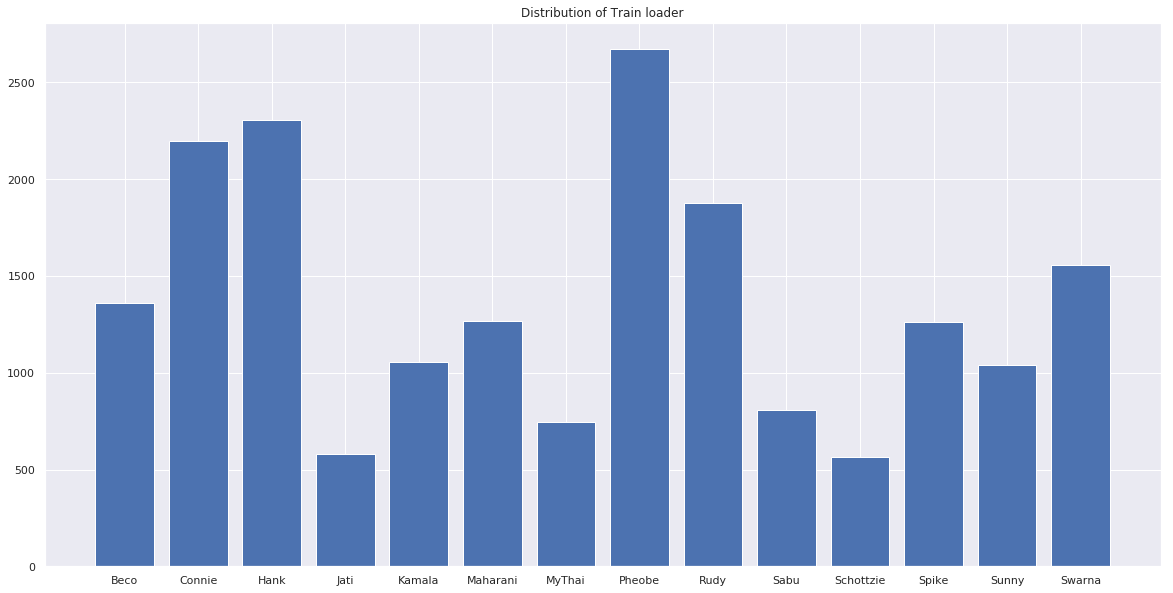

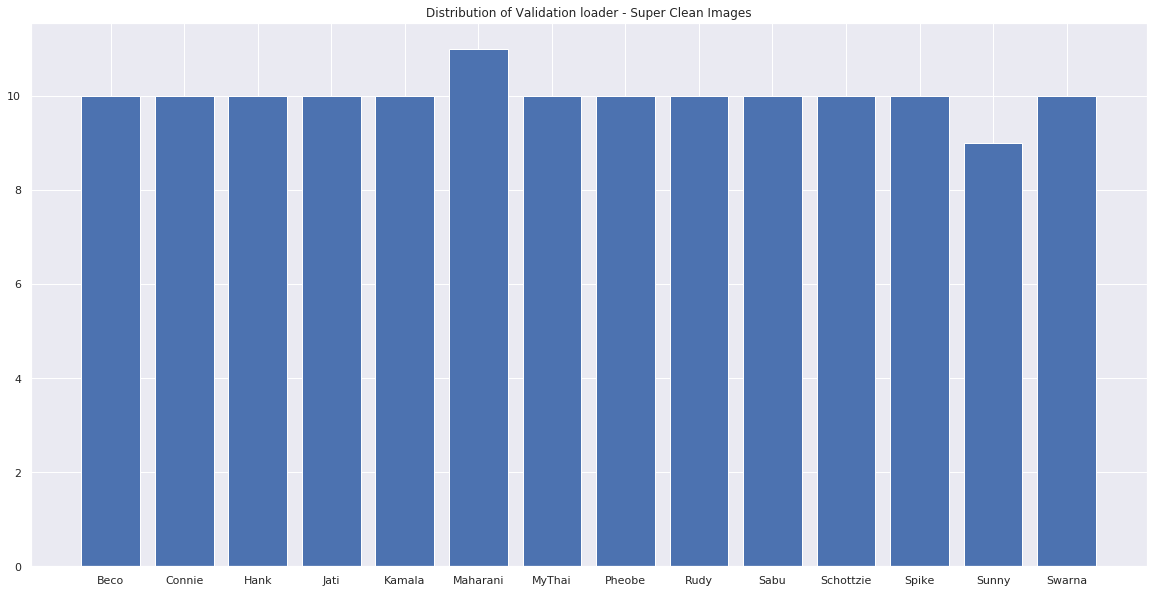

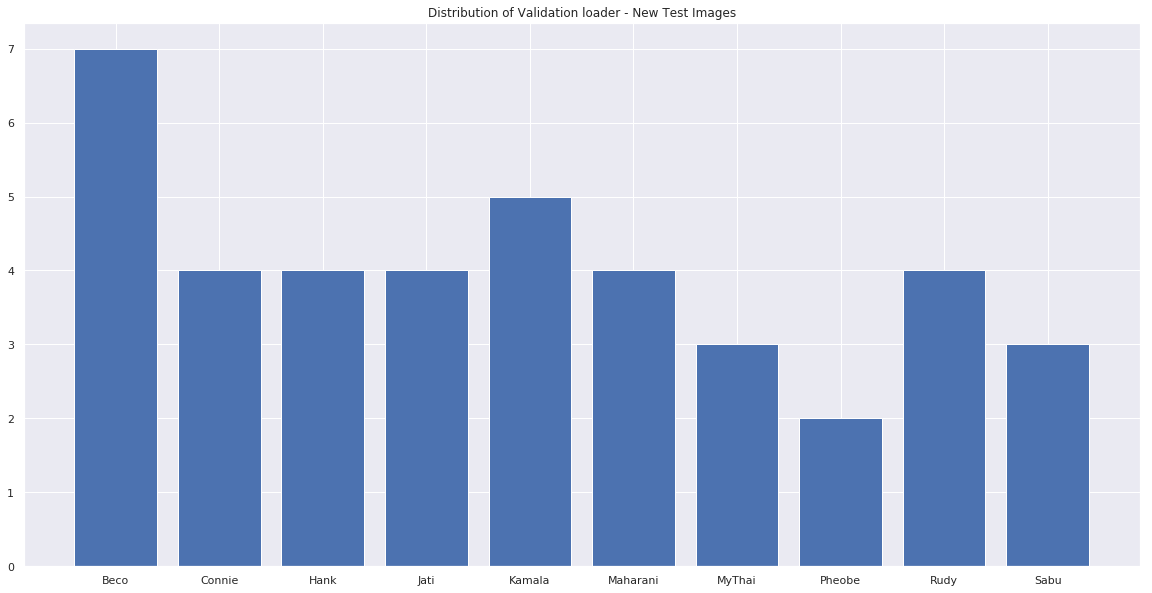

In [95]:
def visualize_distribution_of_dataset(train_loader, val1_loader,val2_loader, classes):

    print('Distribution of classes in trainset dataset:')
    fig, ax = plt.subplots(figsize=(20,10))
    
    labels = [label for _, label in train_loader.dataset.imgs]
    
    classe_labels, counts = np.unique(labels, return_counts=True)
    ax.bar([classes[i] for i in (list(classe_labels))], counts)
    ax.set_xticks(classe_labels)
    plt.title("Distribution of Train loader")
    plt.show()

    fig, ax = plt.subplots(figsize=(20,10))
    labels = [label for _, label in val1_loader.dataset.imgs]
    classe_labels, counts = np.unique(labels, return_counts=True)
    ax.bar([classes[i] for i in (list(classe_labels))], counts)
    ax.set_xticks(classe_labels)
    plt.title("Distribution of Validation loader - Super Clean Images")
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,10))
    labels = [label for _, label in val2_loader.dataset.imgs]
    classe_labels, counts = np.unique(labels, return_counts=True)
    ax.bar([classes[i] for i in (list(classe_labels))], counts)
    ax.set_xticks(classe_labels)
    plt.title("Distribution of Validation loader - New Test Images")
    plt.show()
    
from pylab import rcParams
rcParams['figure.figsize'] = 40, 20

def visualize_images(data_loader):
    
    # helper function to un-normalize and display an image
    def imshow(image,ax=None, title=None):
        if ax is None:
            fig, ax = plt.subplots()
        if title:
            plt.title(title)
    
    
        # PyTorch tensors assume the color channel is first
        # but matplotlib assumes is the third dimension
        #image = image.numpy()
        image = image.transpose((1, 2, 0))

        # Undo preprocessing
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        
        # Image needs to be clipped between 0 and 1
        image = np.clip(image, 0, 1)

        ax.imshow(image)
        
    
    dataiter = iter(data_loader)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(20, 10))

    # display 20 images
    for idx in np.arange(40):
        ax = fig.add_subplot(4, 40/4, idx+1, xticks=[], yticks=[])

        imshow(np.array(images[idx]),ax=ax)
        ax.set_title(classes[labels[idx]])
    
visualize_distribution_of_dataset(train_loader,val1_loader,val2_loader,classes)

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


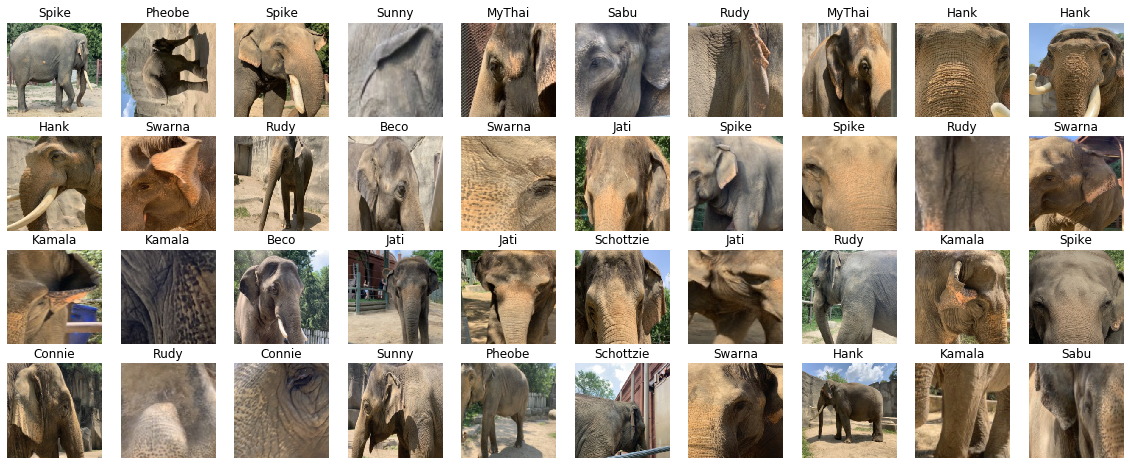

In [9]:
 visualize_images(train_loader)

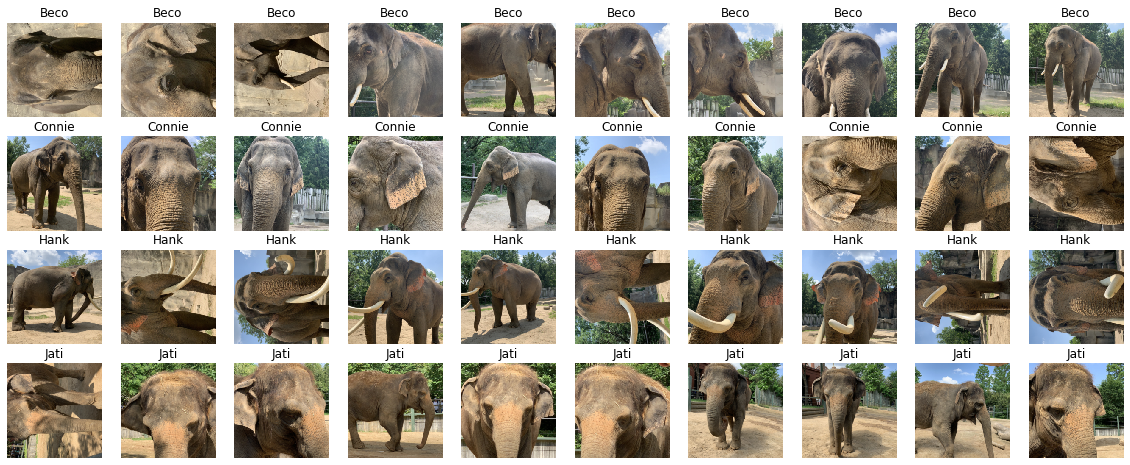

In [10]:
visualize_images(val1_loader)

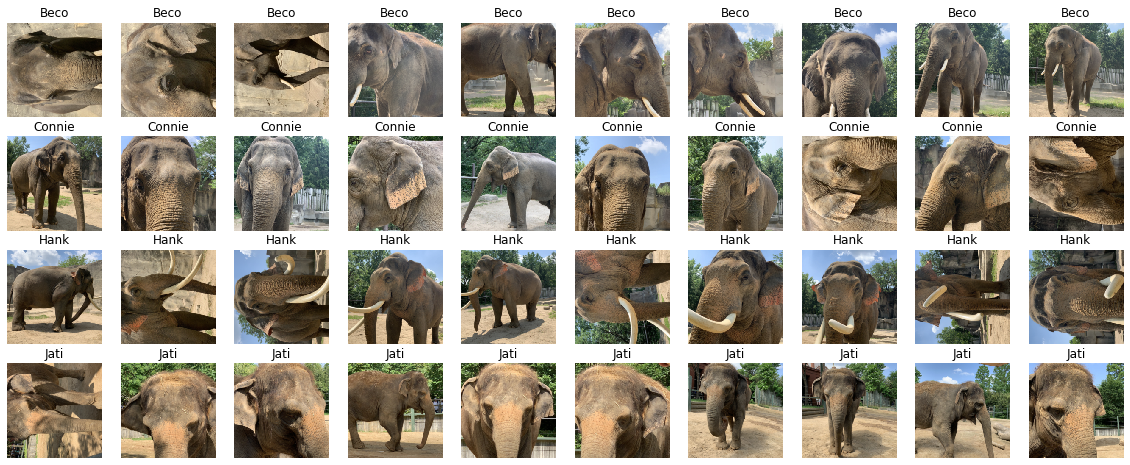

In [20]:
visualize_images(val2_loader)

## Initialize Resnet model

In [7]:
import torch.nn as nn
from torchvision import models 
import sys


In [8]:
use_pretrained = True
model = models.densenet121(pretrained=True)
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 14)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [9]:
use_cuda = torch.cuda.is_available()

if use_cuda:
    model = model.cuda()


### Initialize Optimizer

In [10]:
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0006, momentum=0.9)
criterion = torch.nn.NLLLoss().cuda()

In [45]:
## compute class accuracy for label 0 and 1
import shutil
def compute_accuracy(correct,batch_size,target, class_correct, class_total):
    
    for i in range(batch_size):
        label = target[i]
        class_correct[label]+= correct[i].item()
        
        class_total[label]+=1
    
    return class_correct, class_total
    
def print_accuracy(class_correct, class_total, epoch, model_in = "Train"):
    ## loop through classes
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('%s Epoch: %d, Accuracy of %5s: %2d%% (%2d/%2d)' % (model_in, epoch,classes[i], 
                                                                      
                                                           100 * class_correct[i] / class_total[i],
                                                            np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('%s Epoch: %d: Accuracy of %5s: N/A (no training examples)' % (model_in, epoch, classes[i]))
            
    print('%s  Epoch: %d:  Accuracy (Overall): %2d%% (%2d/%2d)' % (model_in, epoch, 100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total))) 
    

In [46]:
def accuracy_top5(logits, target, topk=(1,5) ):
    with torch.no_grad ():
        output = torch.exp(logits)
        maxk = max ( topk )
        batch_size = target.size ( 0 )
        _, pred = output.topk ( maxk, 1, True, True )
        pred = pred.t()
        correct = pred.eq ( target.view ( 1, -1 ).expand_as ( pred ) )

    res = []
 
    for k in topk:
        
        correct_k = correct[:k].view ( -1 ).float ().sum ( 0, keepdim=True )
        res.append ( correct_k.mul_ ( 100.0 / batch_size ) )
        
    return res


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


    
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

    
    
def save_checkpoint(state, is_best, filename='../checkpoints/checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, '../checkpoints/model_best.pth.tar')
        

In [39]:
import pandas as pd
import seaborn as sns
def visualize_save_plots(train_loss, val_loss, train_acc, val_acc, confusion_matrixes,labels,model_name):
    
    ## loss plot
    ## accuracy plot
    ## confusion matrix, heatamap
    cm = confusion_matrixes[0]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    

    sns.set()
    figsize =(20,20)
    fig = plt.figure(figsize=figsize)
    plt.subplot(2, 2, 1)
    
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.xlabel("epochs")
    plt.ylabel("% accuracy")
    plt.grid(True)
    plt.legend(["train","val"])
    plt.title("Train and Val Accuracy")

    plt.subplot(2, 2, 2)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.xlabel("epochs")
    plt.ylabel("loss value")
    plt.grid(True)
    plt.legend(["train","val"])
    plt.title("Train and Val Loss")

    plt.show()
    
    plt.figure(figsize=(20,20))
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.title("Val accuracy - actual vs predicted")
    plt.show()


In [48]:
import numpy as np
import sklearn.metrics as sm
from tqdm import tqdm

n_epochs = 10

def train(epoch,train_loader,print_freq = 1000):
    
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    
    
    progress = ProgressMeter(
        len(train_loader),
        [losses, top1, top5],
        prefix="Train Epoch: [{}]".format(epoch))
    
    
    ### Train model ##
    model.train()
    print("Epoch:{}/{}".format(epoch,(n_epochs)))
    
    for (data, target) in tqdm((train_loader)):
            
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        ## optimizer zero_grad()
        optimizer.zero_grad()
        
        ## forward pass
        outputs = model(data)
        
        ## calculate batch loss
        loss = criterion(outputs,target)
        
        # measure accuracy and record loss
        acc1, acc5 = accuracy_top5(outputs, target, topk=(1, 5))
        losses.update(loss.item(), data.size(0))
        top1.update(acc1[0], data.size(0))
        top5.update(acc5[0], data.size(0))
        
        
        ## backpropage the loss
        # compute gradient and do  step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        
    print(' Train Epoch: [{}/{}]:  Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'.format(epoch,n_epochs, top1=top1, top5=top5))
    return losses.avg, top1.avg, top5.avg


"""
Validate model
"""
def validate(epoch, val_loader):
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    validation_predictions = []
    targets, preds = [], []
    
    val_class_correct = list(0. for i in range(len(classes)))
    val_class_total = list(0. for i in range(len(classes)))
    
    
    progress = ProgressMeter(
        len(val_loader),
        [losses, top1, top5],
        prefix="Test: Epoch: [{}]".format(epoch))
    
    model.eval()
    with torch.no_grad():
        i = 0 
        for images, target in tqdm(val_loader):
            if use_cuda:
                images, target = images.cuda(), target.cuda()
                
            output = model(images)
            
            loss = criterion(output, target)
            

            # measure accuracy and record loss
            acc1, acc5 = accuracy_top5(output.data.cpu(), target.data.cpu(), topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            
            top1.update(acc1[0].item(), images.size(0))
            top5.update(acc5[0].item(), images.size(0))
            
            
            
            ## predictions
            outputs = torch.exp(output.data.cpu())
            _, pred = outputs.topk(1, dim=1)
            equals = pred == target.data.cpu().view(*pred.shape)
            validation_predictions.append(np.squeeze(pred.numpy()))
            
            ## build confusion matrix
            targets += list(target.cpu().numpy())
            preds += list(pred.numpy())
            confusion_mtx = (sm.confusion_matrix(targets, preds))
            
            
            ## class_correct, class_total
            val_class_correct, val_class_total = compute_accuracy(equals, images.size(0), list(target.cpu().numpy()), val_class_correct,val_class_total)
            
            
            if i % 100 == 0:
                progress.display(i)
            i = i + images.size(0)
            
        print('Test Epoch: [{}/{}]  Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'.format(epoch,n_epochs, top1=top1, top5=top5))
        
        return losses.avg, top1.avg, top5.avg, validation_predictions,confusion_mtx,val_class_correct,val_class_total



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:58<00:00, 58.67s/it]



tensor([[0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

(2.1892330646514893,
 61.42857360839844,
 90.71428680419922,
 [array([12,  4,  0,  5, 11,  5,  5,  0,  0,  1, 11,  1,  1, 13,  1, 12,  1,
         11,  1, 13, 11,  2,  2,  2, 11,  2,  2,  2,  2,  2,  6,  3,  3,  3,
          3,  3,  3,  3, 10, 13,  5,  6, 13,  5, 13,  4,  4,  4,  5,  4,  5,
          5,  5,  5,  5,  2,  5,  5,  5,  5,  5,  6,  6,  6,  6, 13,  6,  6,
          6,  6,  6,  2,  4,  8,  5,  4,  5, 13, 12,  7,  7,  8,  8, 11,  8,
          8,  8,  5,  8,  5,  5,  9,  9,  9,  9, 11,  9,  9,  9,  9,  9,  3,
          7, 10, 10, 10, 10, 10, 10, 10,  5, 11, 11, 11, 11, 11, 12, 11, 11,
         11, 11, 11, 10,  8,  8,  8,  8,  8,  5, 12, 13, 11, 13,  4, 13,  5,
          5, 13, 13, 13])],
 array([[ 3,  1,  0,  0,  1,  3,  0,  0,  0,  0,  0,  1,  1,  0],
        [ 0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  2],
        [ 0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0],
        [ 0,  0,  0,  7,  0,  0,  1,  0,  0,  0,  1,  0,  0,  1],
        [ 0,  0,  0,  0,  4,  3

/N/u/mchivuku/.conda/envs/selfensembling/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


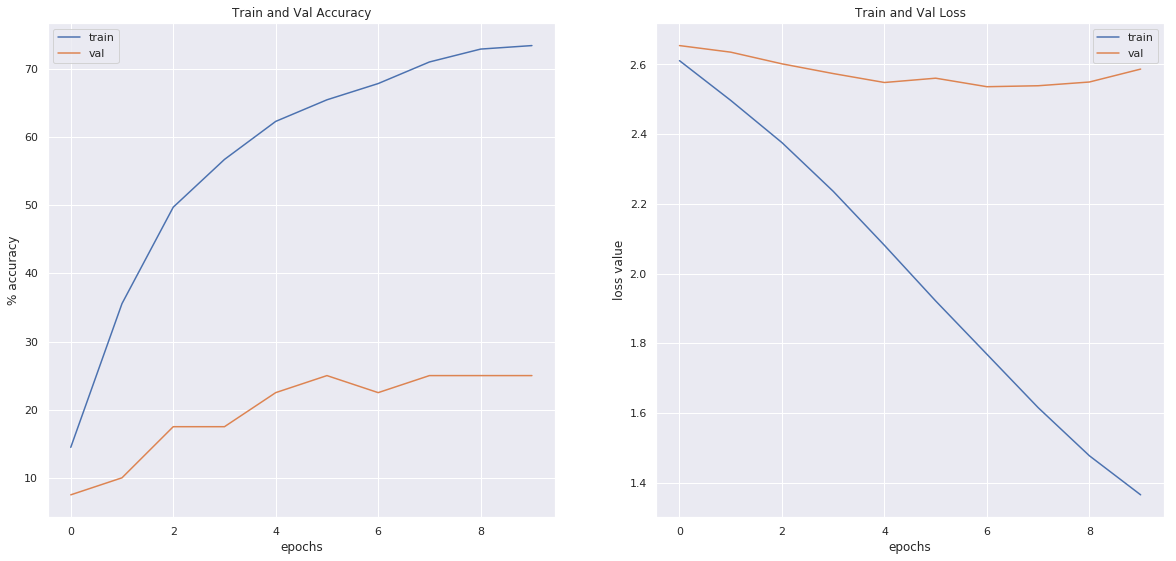

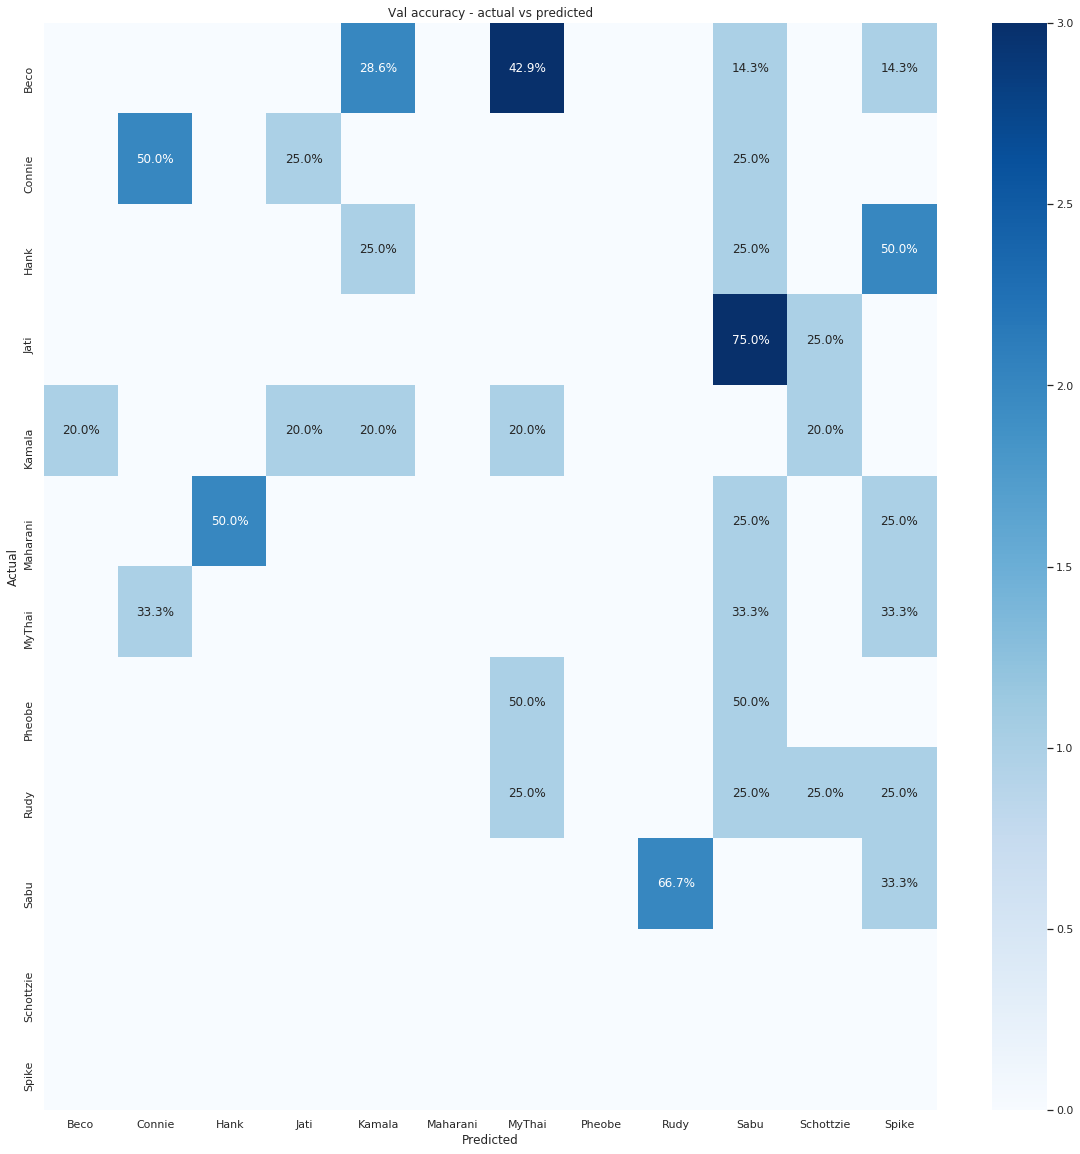

In [49]:
def train_val_model(train_loader, val_loader):
    train_losses = []
    val_losses = []
    validation_loss_min = np.inf
    
    best_model = None
    confusion_mtxes = []
    train_accuracy = []
    val_accuracy = []
    
    train_accuracy5 = []
    val_accuracy5 = []
    
    for epoch in range(1, n_epochs + 1):
        train_loss, train_acc1, train_acc5 = train(epoch,train_loader)
        val_loss, val_acc1, val_acc5, validation_predictions,confusion_mtx,val_class_correct,val_class_total  = validate(epoch, val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        confusion_mtxes.append(confusion_mtx)
        
        train_accuracy.append(train_acc1)
        val_accuracy.append(val_acc1)
        
        train_accuracy5.append(train_acc5)
        val_accuracy5.append(val_acc5)
        
        if val_loss <= validation_loss_min:
            print_accuracy(val_class_correct, val_class_total, epoch, "validation")
            best_model = model
            print("Saving the model")
            save_checkpoint({
                'epoch': epoch + 1,
                'arch': "densenet",
                'state_dict': model.state_dict(),
                'best_acc1': val_acc1,
                'optimizer' : optimizer.state_dict(),
                'best_acc5': val_acc5
            }, True)
            
            validation_loss_min = val_loss
            
        
    return train_losses, val_losses,train_accuracy, val_accuracy, confusion_mtxes,validation_predictions, best_model
        



  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:1/10




  1%|▏         | 1/76 [00:04<06:11,  4.95s/it]

  3%|▎         | 2/76 [00:06<04:52,  3.95s/it]

  4%|▍         | 3/76 [00:08<03:56,  3.24s/it]

  5%|▌         | 4/76 [00:09<03:18,  2.75s/it]

  7%|▋         | 5/76 [00:11<02:51,  2.41s/it]

  8%|▊         | 6/76 [00:12<02:31,  2.16s/it]

  9%|▉         | 7/76 [00:14<02:22,  2.07s/it]

 11%|█         | 8/76 [00:18<02:43,  2.40s/it]

 12%|█▏        | 9/76 [00:20<02:47,  2.49s/it]

 13%|█▎        | 10/76 [00:23<02:59,  2.73s/it]

 14%|█▍        | 11/76 [00:26<02:59,  2.76s/it]

 16%|█▌        | 12/76 [00:29<02:58,  2.79s/it]

 17%|█▋        | 13/76 [00:32<02:55,  2.79s/it]

 18%|█▊        | 14/76 [00:35<02:52,  2.77s/it]

 20%|█▉        | 15/76 [00:38<02:50,  2.79s/it]

 21%|██        | 16/76 [00:41<02:51,  2.85s/it]

 22%|██▏       | 17/76 [00:43<02:48,  2.85s/it]

 24%|██▎       | 18/76 [00:46<02:46,  2.87s/it]

 25%|██▌       | 19/76 [00:49<02:44,  2.89s/it]

 26%|██▋       | 20/76 [00:52<02:45,  2.96s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [1/10]:  Acc@1 61.452 Acc@5 91.669




100%|██████████| 1/1 [00:58<00:00, 58.74s/it]



Test: Epoch: [1][0/1]	Loss 2.0276e+00 (2.0276e+00)	Acc@1  68.57 ( 68.57)	Acc@5  92.14 ( 92.14)
Test Epoch: [1/10]  Acc@1 68.571 Acc@5 92.143
validation Epoch: 1, Accuracy of  Beco: 40% ( 4/10)
validation Epoch: 1, Accuracy of Connie: 70% ( 7/10)
validation Epoch: 1, Accuracy of  Hank: 80% ( 8/10)
validation Epoch: 1, Accuracy of  Jati: 80% ( 8/10)
validation Epoch: 1, Accuracy of Kamala: 40% ( 4/10)
validation Epoch: 1, Accuracy of Maharani: 90% (10/11)
validation Epoch: 1, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 1, Accuracy of Pheobe: 40% ( 4/10)
validation Epoch: 1, Accuracy of  Rudy: 80% ( 8/10)
validation Epoch: 1, Accuracy of  Sabu: 90% ( 9/10)
validation Epoch: 1, Accuracy of Schottzie: 70% ( 7/10)
validation Epoch: 1, Accuracy of Spike: 100% (10/10)
validation Epoch: 1, Accuracy of Sunny: 22% ( 2/ 9)
validation Epoch: 1, Accuracy of Swarna: 60% ( 6/10)
validation  Epoch: 1:  Accuracy (Overall): 68% (96/140)
Saving the model




  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:2/10




  1%|▏         | 1/76 [00:05<06:32,  5.24s/it]

  3%|▎         | 2/76 [00:06<05:06,  4.14s/it]

  4%|▍         | 3/76 [00:08<04:06,  3.37s/it]

  5%|▌         | 4/76 [00:10<03:45,  3.13s/it]

  7%|▋         | 5/76 [00:13<03:33,  3.00s/it]

  8%|▊         | 6/76 [00:16<03:29,  2.99s/it]

  9%|▉         | 7/76 [00:19<03:26,  3.00s/it]

 11%|█         | 8/76 [00:22<03:23,  2.99s/it]

 12%|█▏        | 9/76 [00:25<03:15,  2.91s/it]

 13%|█▎        | 10/76 [00:28<03:10,  2.89s/it]

 14%|█▍        | 11/76 [00:30<03:06,  2.87s/it]

 16%|█▌        | 12/76 [00:33<03:02,  2.85s/it]

 17%|█▋        | 13/76 [00:36<03:02,  2.89s/it]

 18%|█▊        | 14/76 [00:39<03:00,  2.91s/it]

 20%|█▉        | 15/76 [00:42<02:57,  2.91s/it]

 21%|██        | 16/76 [00:45<02:54,  2.90s/it]

 22%|██▏       | 17/76 [00:48<02:50,  2.89s/it]

 24%|██▎       | 18/76 [00:51<02:48,  2.91s/it]

 25%|██▌       | 19/76 [00:54<02:42,  2.86s/it]

 26%|██▋       | 20/76 [00:57<02:45,  2.95s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [2/10]:  Acc@1 65.251 Acc@5 93.230




100%|██████████| 1/1 [01:00<00:00, 60.76s/it]



Test: Epoch: [2][0/1]	Loss 1.8672e+00 (1.8672e+00)	Acc@1  66.43 ( 66.43)	Acc@5  93.57 ( 93.57)
Test Epoch: [2/10]  Acc@1 66.429 Acc@5 93.571
validation Epoch: 2, Accuracy of  Beco: 50% ( 5/10)
validation Epoch: 2, Accuracy of Connie: 40% ( 4/10)
validation Epoch: 2, Accuracy of  Hank: 80% ( 8/10)
validation Epoch: 2, Accuracy of  Jati: 70% ( 7/10)
validation Epoch: 2, Accuracy of Kamala: 40% ( 4/10)
validation Epoch: 2, Accuracy of Maharani: 81% ( 9/11)
validation Epoch: 2, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 2, Accuracy of Pheobe: 40% ( 4/10)
validation Epoch: 2, Accuracy of  Rudy: 80% ( 8/10)
validation Epoch: 2, Accuracy of  Sabu: 80% ( 8/10)
validation Epoch: 2, Accuracy of Schottzie: 80% ( 8/10)
validation Epoch: 2, Accuracy of Spike: 100% (10/10)
validation Epoch: 2, Accuracy of Sunny: 22% ( 2/ 9)
validation Epoch: 2, Accuracy of Swarna: 70% ( 7/10)
validation  Epoch: 2:  Accuracy (Overall): 66% (93/140)
Saving the model




  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:3/10




  1%|▏         | 1/76 [00:05<06:43,  5.38s/it]

  3%|▎         | 2/76 [00:09<06:00,  4.88s/it]

  4%|▍         | 3/76 [00:11<05:09,  4.24s/it]

  5%|▌         | 4/76 [00:14<04:39,  3.89s/it]

  7%|▋         | 5/76 [00:17<04:16,  3.62s/it]

  8%|▊         | 6/76 [00:20<03:57,  3.40s/it]

  9%|▉         | 7/76 [00:23<03:45,  3.27s/it]

 11%|█         | 8/76 [00:26<03:31,  3.11s/it]

 12%|█▏        | 9/76 [00:28<03:09,  2.82s/it]

 13%|█▎        | 10/76 [00:30<02:41,  2.45s/it]

 14%|█▍        | 11/76 [00:31<02:22,  2.19s/it]

 16%|█▌        | 12/76 [00:33<02:08,  2.00s/it]

 17%|█▋        | 13/76 [00:34<01:58,  1.88s/it]

 18%|█▊        | 14/76 [00:36<01:51,  1.80s/it]

 20%|█▉        | 15/76 [00:38<01:45,  1.73s/it]

 21%|██        | 16/76 [00:39<01:41,  1.69s/it]

 22%|██▏       | 17/76 [00:41<01:37,  1.65s/it]

 24%|██▎       | 18/76 [00:43<01:39,  1.72s/it]

 25%|██▌       | 19/76 [00:45<01:55,  2.03s/it]

 26%|██▋       | 20/76 [00:48<02:05,  2.24s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [3/10]:  Acc@1 68.237 Acc@5 94.531




100%|██████████| 1/1 [00:59<00:00, 59.50s/it]



Test: Epoch: [3][0/1]	Loss 1.7075e+00 (1.7075e+00)	Acc@1  73.57 ( 73.57)	Acc@5  96.43 ( 96.43)
Test Epoch: [3/10]  Acc@1 73.571 Acc@5 96.429
validation Epoch: 3, Accuracy of  Beco: 50% ( 5/10)
validation Epoch: 3, Accuracy of Connie: 80% ( 8/10)
validation Epoch: 3, Accuracy of  Hank: 90% ( 9/10)
validation Epoch: 3, Accuracy of  Jati: 70% ( 7/10)
validation Epoch: 3, Accuracy of Kamala: 70% ( 7/10)
validation Epoch: 3, Accuracy of Maharani: 90% (10/11)
validation Epoch: 3, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 3, Accuracy of Pheobe: 50% ( 5/10)
validation Epoch: 3, Accuracy of  Rudy: 80% ( 8/10)
validation Epoch: 3, Accuracy of  Sabu: 80% ( 8/10)
validation Epoch: 3, Accuracy of Schottzie: 80% ( 8/10)
validation Epoch: 3, Accuracy of Spike: 100% (10/10)
validation Epoch: 3, Accuracy of Sunny: 22% ( 2/ 9)
validation Epoch: 3, Accuracy of Swarna: 70% ( 7/10)
validation  Epoch: 3:  Accuracy (Overall): 73% (103/140)
Saving the model




  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:4/10




  1%|▏         | 1/76 [00:04<05:55,  4.74s/it]

  3%|▎         | 2/76 [00:06<04:54,  3.97s/it]

  4%|▍         | 3/76 [00:08<03:59,  3.28s/it]

  5%|▌         | 4/76 [00:10<03:19,  2.77s/it]

  7%|▋         | 5/76 [00:11<02:51,  2.42s/it]

  8%|▊         | 6/76 [00:13<02:31,  2.16s/it]

  9%|▉         | 7/76 [00:14<02:17,  1.99s/it]

 11%|█         | 8/76 [00:16<02:07,  1.88s/it]

 12%|█▏        | 9/76 [00:18<02:00,  1.80s/it]

 13%|█▎        | 10/76 [00:20<02:05,  1.90s/it]

 14%|█▍        | 11/76 [00:23<02:20,  2.16s/it]

 16%|█▌        | 12/76 [00:25<02:30,  2.35s/it]

 17%|█▋        | 13/76 [00:28<02:35,  2.46s/it]

 18%|█▊        | 14/76 [00:31<02:39,  2.58s/it]

 20%|█▉        | 15/76 [00:34<02:41,  2.64s/it]

 21%|██        | 16/76 [00:36<02:39,  2.67s/it]

 22%|██▏       | 17/76 [00:39<02:38,  2.69s/it]

 24%|██▎       | 18/76 [00:42<02:38,  2.72s/it]

 25%|██▌       | 19/76 [00:45<02:35,  2.74s/it]

 26%|██▋       | 20/76 [00:48<02:34,  2.76s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [4/10]:  Acc@1 69.741 Acc@5 94.811




100%|██████████| 1/1 [00:58<00:00, 58.73s/it]



Test: Epoch: [4][0/1]	Loss 1.5605e+00 (1.5605e+00)	Acc@1  77.14 ( 77.14)	Acc@5  96.43 ( 96.43)
Test Epoch: [4/10]  Acc@1 77.143 Acc@5 96.429
validation Epoch: 4, Accuracy of  Beco: 50% ( 5/10)
validation Epoch: 4, Accuracy of Connie: 80% ( 8/10)
validation Epoch: 4, Accuracy of  Hank: 100% (10/10)
validation Epoch: 4, Accuracy of  Jati: 70% ( 7/10)
validation Epoch: 4, Accuracy of Kamala: 90% ( 9/10)
validation Epoch: 4, Accuracy of Maharani: 90% (10/11)
validation Epoch: 4, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 4, Accuracy of Pheobe: 60% ( 6/10)
validation Epoch: 4, Accuracy of  Rudy: 90% ( 9/10)
validation Epoch: 4, Accuracy of  Sabu: 90% ( 9/10)
validation Epoch: 4, Accuracy of Schottzie: 80% ( 8/10)
validation Epoch: 4, Accuracy of Spike: 90% ( 9/10)
validation Epoch: 4, Accuracy of Sunny: 22% ( 2/ 9)
validation Epoch: 4, Accuracy of Swarna: 70% ( 7/10)
validation  Epoch: 4:  Accuracy (Overall): 77% (108/140)
Saving the model




  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:5/10




  1%|▏         | 1/76 [00:04<05:56,  4.75s/it]

  3%|▎         | 2/76 [00:06<04:55,  3.99s/it]

  4%|▍         | 3/76 [00:08<03:58,  3.27s/it]

  5%|▌         | 4/76 [00:10<03:19,  2.77s/it]

  7%|▋         | 5/76 [00:11<02:51,  2.41s/it]

  8%|▊         | 6/76 [00:13<02:32,  2.18s/it]

  9%|▉         | 7/76 [00:14<02:18,  2.01s/it]

 11%|█         | 8/76 [00:17<02:23,  2.11s/it]

 12%|█▏        | 9/76 [00:20<02:34,  2.31s/it]

 13%|█▎        | 10/76 [00:23<02:44,  2.49s/it]

 14%|█▍        | 11/76 [00:25<02:47,  2.58s/it]

 16%|█▌        | 12/76 [00:28<02:52,  2.69s/it]

 17%|█▋        | 13/76 [00:31<02:51,  2.72s/it]

 18%|█▊        | 14/76 [00:34<02:52,  2.78s/it]

 20%|█▉        | 15/76 [00:37<02:49,  2.78s/it]

 21%|██        | 16/76 [00:40<02:48,  2.81s/it]

 22%|██▏       | 17/76 [00:43<02:48,  2.85s/it]

 24%|██▎       | 18/76 [00:45<02:44,  2.84s/it]

 25%|██▌       | 19/76 [00:48<02:41,  2.83s/it]

 26%|██▋       | 20/76 [00:51<02:42,  2.90s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [5/10]:  Acc@1 72.343 Acc@5 95.495




100%|██████████| 1/1 [01:00<00:00, 60.79s/it]



Test: Epoch: [5][0/1]	Loss 1.4107e+00 (1.4107e+00)	Acc@1  77.86 ( 77.86)	Acc@5  97.14 ( 97.14)
Test Epoch: [5/10]  Acc@1 77.857 Acc@5 97.143
validation Epoch: 5, Accuracy of  Beco: 60% ( 6/10)
validation Epoch: 5, Accuracy of Connie: 80% ( 8/10)
validation Epoch: 5, Accuracy of  Hank: 100% (10/10)
validation Epoch: 5, Accuracy of  Jati: 80% ( 8/10)
validation Epoch: 5, Accuracy of Kamala: 70% ( 7/10)
validation Epoch: 5, Accuracy of Maharani: 90% (10/11)
validation Epoch: 5, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 5, Accuracy of Pheobe: 50% ( 5/10)
validation Epoch: 5, Accuracy of  Rudy: 80% ( 8/10)
validation Epoch: 5, Accuracy of  Sabu: 90% ( 9/10)
validation Epoch: 5, Accuracy of Schottzie: 80% ( 8/10)
validation Epoch: 5, Accuracy of Spike: 100% (10/10)
validation Epoch: 5, Accuracy of Sunny: 44% ( 4/ 9)
validation Epoch: 5, Accuracy of Swarna: 70% ( 7/10)
validation  Epoch: 5:  Accuracy (Overall): 77% (109/140)
Saving the model




  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:6/10




  1%|▏         | 1/76 [00:05<07:17,  5.83s/it]

  3%|▎         | 2/76 [00:08<06:05,  4.94s/it]

  4%|▍         | 3/76 [00:11<05:15,  4.32s/it]

  5%|▌         | 4/76 [00:14<04:40,  3.89s/it]

  7%|▋         | 5/76 [00:17<04:12,  3.56s/it]

  8%|▊         | 6/76 [00:19<03:40,  3.15s/it]

  9%|▉         | 7/76 [00:21<03:04,  2.68s/it]

 11%|█         | 8/76 [00:22<02:40,  2.36s/it]

 12%|█▏        | 9/76 [00:24<02:22,  2.12s/it]

 13%|█▎        | 10/76 [00:25<02:09,  1.97s/it]

 14%|█▍        | 11/76 [00:27<02:00,  1.86s/it]

 16%|█▌        | 12/76 [00:28<01:53,  1.77s/it]

 17%|█▋        | 13/76 [00:30<01:49,  1.73s/it]

 18%|█▊        | 14/76 [00:32<01:45,  1.70s/it]

 20%|█▉        | 15/76 [00:33<01:42,  1.69s/it]

 21%|██        | 16/76 [00:36<02:02,  2.04s/it]

 22%|██▏       | 17/76 [00:39<02:14,  2.28s/it]

 24%|██▎       | 18/76 [00:42<02:24,  2.48s/it]

 25%|██▌       | 19/76 [00:45<02:27,  2.59s/it]

 26%|██▋       | 20/76 [00:48<02:28,  2.64s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [6/10]:  Acc@1 73.556 Acc@5 96.091




100%|██████████| 1/1 [00:58<00:00, 58.39s/it]



Test: Epoch: [6][0/1]	Loss 1.2960e+00 (1.2960e+00)	Acc@1  80.00 ( 80.00)	Acc@5  97.14 ( 97.14)
Test Epoch: [6/10]  Acc@1 80.000 Acc@5 97.143
validation Epoch: 6, Accuracy of  Beco: 50% ( 5/10)
validation Epoch: 6, Accuracy of Connie: 80% ( 8/10)
validation Epoch: 6, Accuracy of  Hank: 100% (10/10)
validation Epoch: 6, Accuracy of  Jati: 80% ( 8/10)
validation Epoch: 6, Accuracy of Kamala: 90% ( 9/10)
validation Epoch: 6, Accuracy of Maharani: 90% (10/11)
validation Epoch: 6, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 6, Accuracy of Pheobe: 60% ( 6/10)
validation Epoch: 6, Accuracy of  Rudy: 100% (10/10)
validation Epoch: 6, Accuracy of  Sabu: 90% ( 9/10)
validation Epoch: 6, Accuracy of Schottzie: 80% ( 8/10)
validation Epoch: 6, Accuracy of Spike: 100% (10/10)
validation Epoch: 6, Accuracy of Sunny: 33% ( 3/ 9)
validation Epoch: 6, Accuracy of Swarna: 70% ( 7/10)
validation  Epoch: 6:  Accuracy (Overall): 80% (112/140)
Saving the model




  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:7/10




  1%|▏         | 1/76 [00:05<06:17,  5.04s/it]

  3%|▎         | 2/76 [00:06<04:56,  4.00s/it]

  4%|▍         | 3/76 [00:08<03:59,  3.28s/it]

  5%|▌         | 4/76 [00:09<03:21,  2.80s/it]

  7%|▋         | 5/76 [00:11<03:01,  2.56s/it]

  8%|▊         | 6/76 [00:14<03:06,  2.67s/it]

  9%|▉         | 7/76 [00:17<03:08,  2.73s/it]

 11%|█         | 8/76 [00:20<03:06,  2.75s/it]

 12%|█▏        | 9/76 [00:23<03:06,  2.78s/it]

 13%|█▎        | 10/76 [00:26<03:03,  2.78s/it]

 14%|█▍        | 11/76 [00:29<03:03,  2.82s/it]

 16%|█▌        | 12/76 [00:31<03:02,  2.84s/it]

 17%|█▋        | 13/76 [00:34<02:57,  2.81s/it]

 18%|█▊        | 14/76 [00:37<02:55,  2.82s/it]

 20%|█▉        | 15/76 [00:40<02:53,  2.85s/it]

 21%|██        | 16/76 [00:43<02:51,  2.87s/it]

 22%|██▏       | 17/76 [00:46<02:54,  2.95s/it]

 24%|██▎       | 18/76 [00:49<02:51,  2.95s/it]

 25%|██▌       | 19/76 [00:52<02:46,  2.93s/it]

 26%|██▋       | 20/76 [00:55<02:43,  2.91s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [7/10]:  Acc@1 74.681 Acc@5 96.096




100%|██████████| 1/1 [00:59<00:00, 59.18s/it]



Test: Epoch: [7][0/1]	Loss 1.1769e+00 (1.1769e+00)	Acc@1  82.86 ( 82.86)	Acc@5  97.14 ( 97.14)
Test Epoch: [7/10]  Acc@1 82.857 Acc@5 97.143
validation Epoch: 7, Accuracy of  Beco: 60% ( 6/10)
validation Epoch: 7, Accuracy of Connie: 80% ( 8/10)
validation Epoch: 7, Accuracy of  Hank: 100% (10/10)
validation Epoch: 7, Accuracy of  Jati: 80% ( 8/10)
validation Epoch: 7, Accuracy of Kamala: 80% ( 8/10)
validation Epoch: 7, Accuracy of Maharani: 90% (10/11)
validation Epoch: 7, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 7, Accuracy of Pheobe: 70% ( 7/10)
validation Epoch: 7, Accuracy of  Rudy: 90% ( 9/10)
validation Epoch: 7, Accuracy of  Sabu: 90% ( 9/10)
validation Epoch: 7, Accuracy of Schottzie: 90% ( 9/10)
validation Epoch: 7, Accuracy of Spike: 100% (10/10)
validation Epoch: 7, Accuracy of Sunny: 66% ( 6/ 9)
validation Epoch: 7, Accuracy of Swarna: 70% ( 7/10)
validation  Epoch: 7:  Accuracy (Overall): 82% (116/140)
Saving the model




  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:8/10




  1%|▏         | 1/76 [00:05<07:14,  5.80s/it]

  3%|▎         | 2/76 [00:08<06:01,  4.88s/it]

  4%|▍         | 3/76 [00:11<05:08,  4.23s/it]

  5%|▌         | 4/76 [00:14<04:35,  3.82s/it]

  7%|▋         | 5/76 [00:16<04:08,  3.50s/it]

  8%|▊         | 6/76 [00:19<03:50,  3.29s/it]

  9%|▉         | 7/76 [00:22<03:34,  3.11s/it]

 11%|█         | 8/76 [00:25<03:29,  3.08s/it]

 12%|█▏        | 9/76 [00:28<03:22,  3.02s/it]

 13%|█▎        | 10/76 [00:31<03:14,  2.95s/it]

 14%|█▍        | 11/76 [00:34<03:12,  2.96s/it]

 16%|█▌        | 12/76 [00:36<03:05,  2.90s/it]

 17%|█▋        | 13/76 [00:39<03:02,  2.89s/it]

 18%|█▊        | 14/76 [00:42<02:58,  2.88s/it]

 20%|█▉        | 15/76 [00:45<02:53,  2.84s/it]

 21%|██        | 16/76 [00:47<02:31,  2.53s/it]

 22%|██▏       | 17/76 [00:48<02:12,  2.24s/it]

 24%|██▎       | 18/76 [00:50<01:58,  2.05s/it]

 25%|██▌       | 19/76 [00:51<01:48,  1.90s/it]

 26%|██▋       | 20/76 [00:53<01:41,  1.81s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [8/10]:  Acc@1 76.407 Acc@5 96.361




100%|██████████| 1/1 [00:58<00:00, 58.28s/it]



Test: Epoch: [8][0/1]	Loss 1.0947e+00 (1.0947e+00)	Acc@1  83.57 ( 83.57)	Acc@5  97.14 ( 97.14)
Test Epoch: [8/10]  Acc@1 83.571 Acc@5 97.143
validation Epoch: 8, Accuracy of  Beco: 60% ( 6/10)
validation Epoch: 8, Accuracy of Connie: 80% ( 8/10)
validation Epoch: 8, Accuracy of  Hank: 100% (10/10)
validation Epoch: 8, Accuracy of  Jati: 80% ( 8/10)
validation Epoch: 8, Accuracy of Kamala: 90% ( 9/10)
validation Epoch: 8, Accuracy of Maharani: 90% (10/11)
validation Epoch: 8, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 8, Accuracy of Pheobe: 70% ( 7/10)
validation Epoch: 8, Accuracy of  Rudy: 90% ( 9/10)
validation Epoch: 8, Accuracy of  Sabu: 90% ( 9/10)
validation Epoch: 8, Accuracy of Schottzie: 90% ( 9/10)
validation Epoch: 8, Accuracy of Spike: 100% (10/10)
validation Epoch: 8, Accuracy of Sunny: 55% ( 5/ 9)
validation Epoch: 8, Accuracy of Swarna: 80% ( 8/10)
validation  Epoch: 8:  Accuracy (Overall): 83% (117/140)
Saving the model




  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:9/10




  1%|▏         | 1/76 [00:06<07:36,  6.09s/it]

  3%|▎         | 2/76 [00:08<06:19,  5.13s/it]

  4%|▍         | 3/76 [00:11<05:25,  4.45s/it]

  5%|▌         | 4/76 [00:14<04:47,  3.99s/it]

  7%|▋         | 5/76 [00:17<04:17,  3.63s/it]

  8%|▊         | 6/76 [00:20<03:57,  3.40s/it]

  9%|▉         | 7/76 [00:23<03:43,  3.24s/it]

 11%|█         | 8/76 [00:25<03:18,  2.92s/it]

 12%|█▏        | 9/76 [00:27<02:48,  2.51s/it]

 13%|█▎        | 10/76 [00:28<02:27,  2.23s/it]

 14%|█▍        | 11/76 [00:30<02:12,  2.03s/it]

 16%|█▌        | 12/76 [00:31<02:01,  1.90s/it]

 17%|█▋        | 13/76 [00:33<01:54,  1.81s/it]

 18%|█▊        | 14/76 [00:34<01:47,  1.74s/it]

 20%|█▉        | 15/76 [00:36<01:43,  1.69s/it]

 21%|██        | 16/76 [00:38<01:39,  1.66s/it]

 22%|██▏       | 17/76 [00:39<01:38,  1.67s/it]

 24%|██▎       | 18/76 [00:42<01:58,  2.04s/it]

 25%|██▌       | 19/76 [00:45<02:09,  2.27s/it]

 26%|██▋       | 20/76 [00:48<02:20,  2.51s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [9/10]:  Acc@1 76.428 Acc@5 96.340




100%|██████████| 1/1 [00:58<00:00, 58.79s/it]



Test: Epoch: [9][0/1]	Loss 1.0248e+00 (1.0248e+00)	Acc@1  85.00 ( 85.00)	Acc@5  97.86 ( 97.86)
Test Epoch: [9/10]  Acc@1 85.000 Acc@5 97.857
validation Epoch: 9, Accuracy of  Beco: 60% ( 6/10)
validation Epoch: 9, Accuracy of Connie: 80% ( 8/10)
validation Epoch: 9, Accuracy of  Hank: 100% (10/10)
validation Epoch: 9, Accuracy of  Jati: 80% ( 8/10)
validation Epoch: 9, Accuracy of Kamala: 90% ( 9/10)
validation Epoch: 9, Accuracy of Maharani: 90% (10/11)
validation Epoch: 9, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 9, Accuracy of Pheobe: 80% ( 8/10)
validation Epoch: 9, Accuracy of  Rudy: 90% ( 9/10)
validation Epoch: 9, Accuracy of  Sabu: 90% ( 9/10)
validation Epoch: 9, Accuracy of Schottzie: 90% ( 9/10)
validation Epoch: 9, Accuracy of Spike: 100% (10/10)
validation Epoch: 9, Accuracy of Sunny: 66% ( 6/ 9)
validation Epoch: 9, Accuracy of Swarna: 80% ( 8/10)
validation  Epoch: 9:  Accuracy (Overall): 85% (119/140)
Saving the model




  0%|          | 0/76 [00:00<?, ?it/s]

Epoch:10/10




  1%|▏         | 1/76 [00:04<05:37,  4.50s/it]

  3%|▎         | 2/76 [00:06<04:39,  3.77s/it]

  4%|▍         | 3/76 [00:08<03:49,  3.14s/it]

  5%|▌         | 4/76 [00:09<03:12,  2.68s/it]

  7%|▋         | 5/76 [00:11<02:46,  2.35s/it]

  8%|▊         | 6/76 [00:13<02:28,  2.12s/it]

  9%|▉         | 7/76 [00:14<02:15,  1.97s/it]

 11%|█         | 8/76 [00:16<02:16,  2.01s/it]

 12%|█▏        | 9/76 [00:19<02:28,  2.22s/it]

 13%|█▎        | 10/76 [00:22<02:39,  2.41s/it]

 14%|█▍        | 11/76 [00:25<02:48,  2.59s/it]

 16%|█▌        | 12/76 [00:28<02:48,  2.63s/it]

 17%|█▋        | 13/76 [00:30<02:52,  2.74s/it]

 18%|█▊        | 14/76 [00:33<02:52,  2.78s/it]

 20%|█▉        | 15/76 [00:36<02:50,  2.79s/it]

 21%|██        | 16/76 [00:39<02:47,  2.79s/it]

 22%|██▏       | 17/76 [00:42<02:46,  2.82s/it]

 24%|██▎       | 18/76 [00:45<02:45,  2.85s/it]

 25%|██▌       | 19/76 [00:48<02:40,  2.82s/it]

 26%|██▋       | 20/76 [00:50<02:37,  2.81s/it]

 28%|██▊       | 21/76 [00:

 Train Epoch: [10/10]:  Acc@1 77.646 Acc@5 96.786




100%|██████████| 1/1 [00:58<00:00, 58.83s/it]



Test: Epoch: [10][0/1]	Loss 9.4705e-01 (9.4705e-01)	Acc@1  84.29 ( 84.29)	Acc@5  97.86 ( 97.86)
Test Epoch: [10/10]  Acc@1 84.286 Acc@5 97.857
validation Epoch: 10, Accuracy of  Beco: 50% ( 5/10)
validation Epoch: 10, Accuracy of Connie: 80% ( 8/10)
validation Epoch: 10, Accuracy of  Hank: 100% (10/10)
validation Epoch: 10, Accuracy of  Jati: 80% ( 8/10)
validation Epoch: 10, Accuracy of Kamala: 90% ( 9/10)
validation Epoch: 10, Accuracy of Maharani: 90% (10/11)
validation Epoch: 10, Accuracy of MyThai: 90% ( 9/10)
validation Epoch: 10, Accuracy of Pheobe: 90% ( 9/10)
validation Epoch: 10, Accuracy of  Rudy: 90% ( 9/10)
validation Epoch: 10, Accuracy of  Sabu: 90% ( 9/10)
validation Epoch: 10, Accuracy of Schottzie: 90% ( 9/10)
validation Epoch: 10, Accuracy of Spike: 100% (10/10)
validation Epoch: 10, Accuracy of Sunny: 55% ( 5/ 9)
validation Epoch: 10, Accuracy of Swarna: 80% ( 8/10)
validation  Epoch: 10:  Accuracy (Overall): 84% (118/140)
Saving the model
85.0 tensor(77.6464, devic

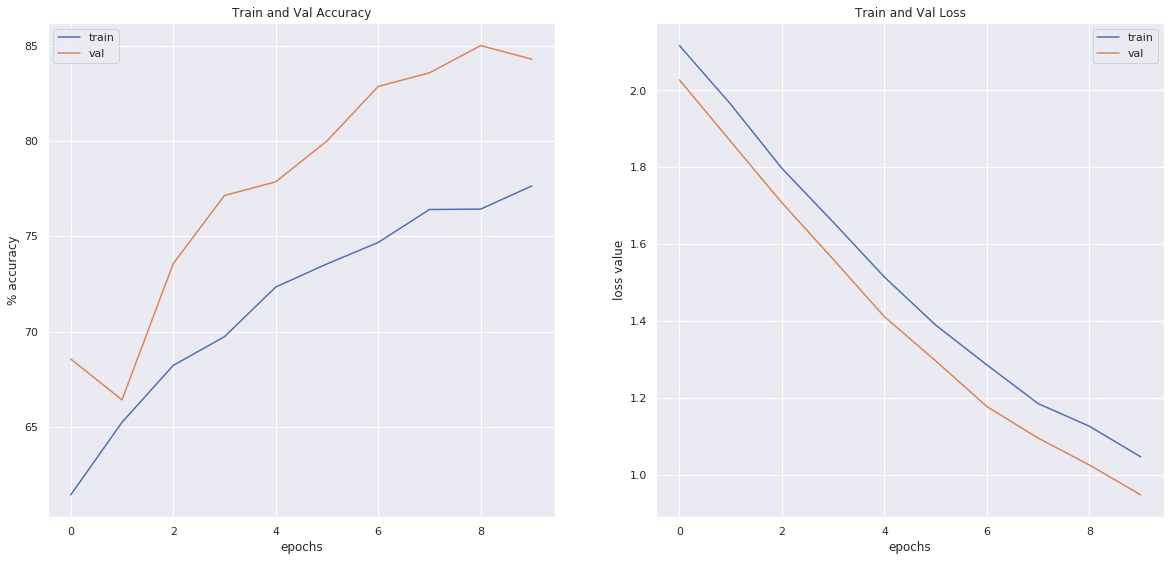

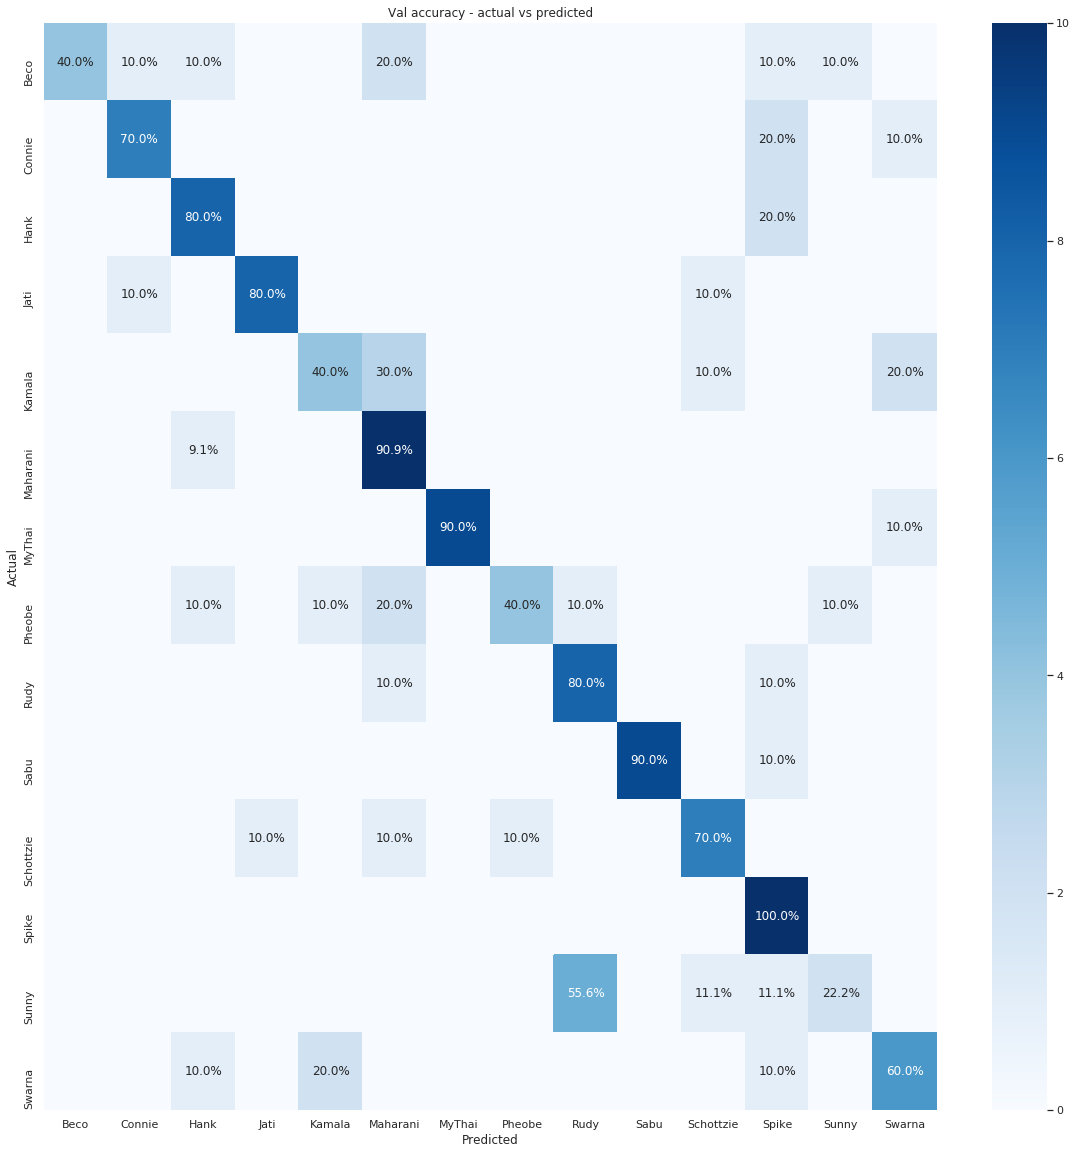

In [50]:
train_losses, val_losses,train_accuracy, val_accuracy, confusion_mtxes,validation_predictions, best_model = train_val_model(train_loader, val1_loader)
print(max(val_accuracy), max(train_accuracy))
visualize_save_plots(train_losses,val_losses,train_accuracy,val_accuracy,confusion_mtxes,classes,"densenet")

In [51]:
print(max(val_accuracy), max(train_accuracy))

85.0 tensor(77.6464, device='cuda:0')


In [52]:
validation_predictions
images, labels = next(iter(val1_loader))
print(labels, validation_predictions[:len(labels)])
len(val1_loader.dataset)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]) [array([ 8,  7,  0,  5,  5,  2,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
       11,  1, 13,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  6,  3,  3,  3,
        3,  3,  3,  3, 10,  3,  4,  7,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  7,  5,  5,  5,  5,  5,  6,  6,  6,  6, 12,  6,  6,
        6,  6,  6,  7,  1,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,

140

## Load the best model And Evaluate New Test Set

In [57]:
model = best_model
val_loss, val_acc1, val_acc5, validation_predictions,confusion_mtx,val_class_correct,val_class_total = validate(1, val2_loader)

validation_predictions
images, labels = next(iter(val2_loader))
print(labels, validation_predictions[:len(labels)])
len(val2_loader.dataset)




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:09<00:00,  9.33s/it]



Test: Epoch: [1][0/1]	Loss 2.6466e+00 (2.6466e+00)	Acc@1  30.00 ( 30.00)	Acc@5  62.50 ( 62.50)
Test Epoch: [1/10]  Acc@1 30.000 Acc@5 62.500
tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        5, 5, 5, 5, 6, 6, 6, 7, 7, 8, 8, 8, 8, 9, 9, 9]) [array([ 8,  8,  9,  9,  8,  0,  0,  1,  5,  5,  5,  2,  2,  2,  2,  6,  6,
        6,  4,  6,  0, 12,  6,  6,  5,  7,  5,  7,  9,  5,  7,  5,  0,  8,
        8,  8, 12, 12,  8, 12])]


40

In [67]:
cm

Predicted  0   1   2   3   4   5   6   7   8   9   10
Actual                                               
0           2   0   0   0   0   0   0   0   3   2   0
1           0   1   0   0   0   3   0   0   0   0   0
2           0   0   4   0   0   0   0   0   0   0   0
3           0   0   0   0   1   0   3   0   0   0   0
4           1   0   0   0   0   0   3   0   0   0   1
5           0   0   0   0   0   2   0   2   0   0   0
6           0   0   0   0   0   1   0   1   0   1   0
7           1   0   0   0   0   1   0   0   0   0   0
8           0   0   0   0   0   0   0   0   3   0   1
9           0   0   0   0   0   0   0   0   1   0   2
10          0   0   0   0   0   0   0   0   0   0   0

### GRAD CAM

In [72]:
import cv2
files = []
d = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(data_path,"val")):
     for f in (filenames):
            path = os.path.join(dirpath,f)
            image = cv2.imread(path)
            if image is None:
                continue
            files.append(path)
            label = os.path.basename(dirpath)
            d.append(label)

In [76]:
print(f" No of files: {len(files)}, no of labels:{len(d)}")


model

 No of files: 140, no of labels:140


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [77]:
model.eval()
class DenseNet(nn.Module):
    def __init__(self,model):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        #h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1024))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [78]:
import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys

import random

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.utils import save_image
from torchvision.models import densenet121
from torchvision.transforms import functional as tf

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True


model.eval()


new_model = DenseNet(model)
val1_loader = torch.utils.data.DataLoader(subset["val1"], batch_size=1, **kwargs)

In [79]:
# get the image from the dataloader

import cv2
import ntpath
for idx, (img, label) in enumerate(val1_loader):
    # get the most likely prediction of the model
    pred = new_model(img.cuda()).argmax(dim=1)
    
    # get the activations of the last convolutional layer
    activations = new_model.get_activations(img.cuda()).detach()
    
    # average the channels of the activations
    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.numpy()
    
        
    print(files[idx])
    label_name = d[idx]
    
    
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + image
    
    ## savepath
    save_path = os.path.join("../results/grad_cam_super_clean_val_images",d[idx])
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    cv2.imwrite(os.path.join(save_path,ntpath.basename(files[idx])), superimposed_img)


../data/dataset/val/Sunny/IMG_9473.JPG
../data/dataset/val/Sunny/IMG_9346.JPG
../data/dataset/val/Sunny/IMG_9728.JPG
../data/dataset/val/Sunny/IMG_7828.JPG
../data/dataset/val/Sunny/IMG_9144.JPG
../data/dataset/val/Sunny/IMG_9637.JPG
../data/dataset/val/Sunny/IMG_9518.JPG
../data/dataset/val/Sunny/IMG_8107.JPG
../data/dataset/val/Sunny/IMG_9419.JPG
../data/dataset/val/Spike/IMG_0988.JPG
../data/dataset/val/Spike/IMG_1240.JPG
../data/dataset/val/Spike/IMG_0114.JPG
../data/dataset/val/Spike/IMG_1344.JPG
../data/dataset/val/Spike/IMG_1115.JPG
../data/dataset/val/Spike/IMG_1192.JPG
../data/dataset/val/Spike/IMG_0944.JPG
../data/dataset/val/Spike/IMG_1056.JPG
../data/dataset/val/Spike/IMG_0807.JPG
../data/dataset/val/Spike/IMG_1259.JPG
../data/dataset/val/Swarna/IMG_9477.JPG
../data/dataset/val/Swarna/IMG_9805.JPG
../data/dataset/val/Swarna/IMG_9801.JPG
../data/dataset/val/Swarna/IMG_9852.JPG
../data/dataset/val/Swarna/IMG_0013.JPG
../data/dataset/val/Swarna/IMG_9901.JPG
../data/dataset/val

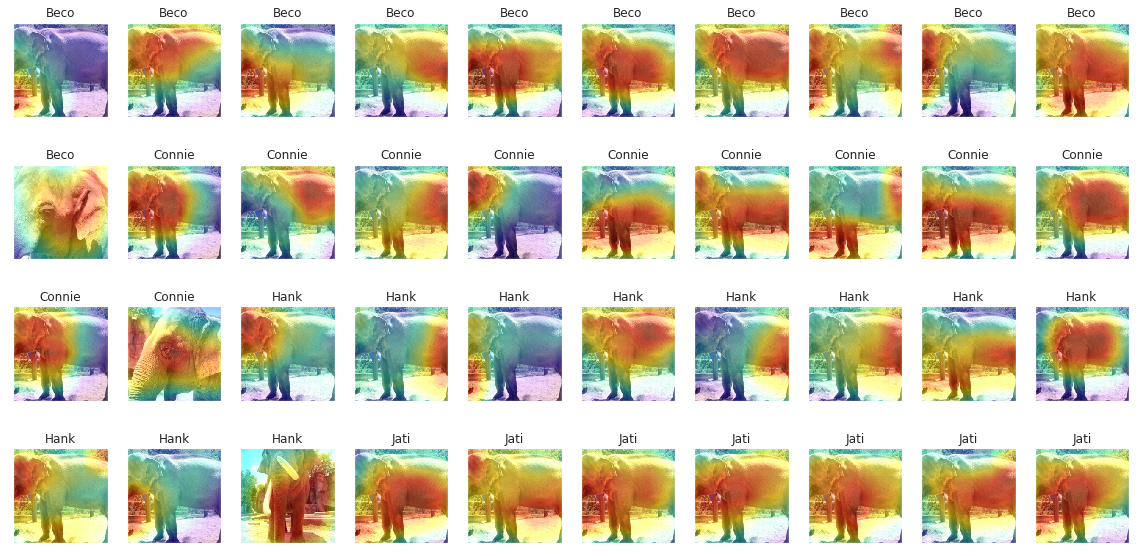

In [97]:

classes = ["Beco", "Connie", "Hank",  
                "Jati",  "Kamala",  "Maharani",  "MyThai", "Pheobe" ,"Rudy", "Sabu", 
                "Schottzie", "Spike", 
                "Sunny", "Swarna"]

grad_cam_loader = torch.utils.data.DataLoader(subset["grad_cam"],batch_size=batch_size, **kwargs)

visualize_images(grad_cam_loader)

In [88]:
print(len(grad_cam_loader))

1


In [89]:
print(subset["grad_cam"],)

Dataset ImageFolder
    Number of datapoints: 153
    Root Location: ../results/grad_cam_super_clean_val_images
    Transforms (if any): None
    Target Transforms (if any): None
